# Phase 3 Project, book 1

Welcome to my Phase 3 notebook. This notebook will go through my Phase 3 project, which will involve a classification problem. Using logisitc regression, random forests, ensemble methods etc. So let's get started.

## The problem:
Using the data below, predict whether or not a bottle of whisky will be "expensive" (>$100USD) or not. I'll be using a number of modeling functions. Potentially this could be used in an app where the user can provide some of the information we'll be using, such as country and type, and it could give a simple yes or no prediction.

### Step 1: Importing libraries
Right here I'm importing vitrually every library I can think of that might help with this problem.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score
from sklearn.metrics import recall_score, f1_score,roc_auc_score ,plot_roc_curve, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline

### Step 2: Read the data

In [2]:
df=pd.read_csv('Meta-Critic Whisky Database.csv')

In [3]:
df.head()

,Whisky,Meta Critic,STDEV,#,Cost,Class,Super Cluster,Cluster,Country,Type
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
1,Ledaig 42yo Dusgadh,9.48,0.23,3,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt
3,Glenfarclas 40yo,9.29,0.26,17,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
4,Glengoyne 25yo,9.24,0.22,21,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 10 columns):
Whisky           1767 non-null object
Meta Critic      1767 non-null object
STDEV            1767 non-null object
#                1767 non-null int64
Cost             1766 non-null object
Class            1767 non-null object
Super Cluster    1180 non-null object
Cluster          1457 non-null object
Country          1767 non-null object
Type             1767 non-null object
dtypes: int64(1), object(9)
memory usage: 138.2+ KB


So there are a few nulls in the data, but not too many. I know I don't want to use 'Super Cluster' in my models, so I can drop that right away.

In [5]:
df.drop('Super Cluster',axis=1,inplace=True)

### Step 3: Assign the target variable

I know that Cost is going to be my target variable. So let's look at it real quick.

In [6]:
df['Cost'].value_counts()

$$$$      601
$$$$$     352
$$$       334
$$        205
$$$$$+    185
$          89
Name: Cost, dtype: int64

And we know there's 1 null value.

In [7]:
df.loc[df.Cost.isna()]

,Whisky,Meta Critic,STDEV,#,Cost,Class,Cluster,Country,Type
587,Teaninich 10yo (F&F),8.29,0.18,4,NaN,SingleMalt-like,F,Scotland,Malt


What I'd like to do is get these $'s into numbers, then into 1's and 0's. Let's try to see if we can get a length for these elements. First things first, let's get rid of that single null value.

### Step 4: Process the data

In [8]:
df=df.dropna(subset=['Cost'])

And from further exploration of the data, I know there's 1 invalid value in 'Meta Critic', so let's look at that and get rid of it.

In [9]:
df.loc[df['Meta Critic'] == '#REF!']

,Whisky,Meta Critic,STDEV,#,Cost,Class,Cluster,Country,Type
1179,Bruichladdich Octomore 10 (Fourth Edition),#REF!,#REF!,3,$$$$$,SingleMalt-like,J,Scotland,Malt


In [10]:
i=df[((df['Meta Critic'] == '#REF!') )].index

In [11]:
df.drop(i, inplace=True)

Getting back to our target variable. I think the easiest way to do this is to do my sorting by length.

In [12]:
len(df['Cost'][0])

6

In [13]:
len(df['Cost'][55])

5

So what've learned is we can split these up by length. And we know that 4 dollar signs is about $100 USD, that's a nice place to split it.

In [14]:
Target=df['Cost']
df1=df.drop('Cost',axis=1)

In [15]:
df1.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt


Ok, so we got our target variable separate from the data. Now we need to do a few things to get the data in working condition. First we need our target dataset to be a 1 or 0 based on our criteria. So anything above 4 dollar signs will be classified as 'expensive', it'll get assigned to 1. Everything else will be 0. So let's make that happen.

In [16]:
type(Target)

pandas.core.series.Series

In [17]:
Target.unique()

array(['$$$$$+', '$$$$$', '$$$$', '$$', '$$$', '$'], dtype=object)

In [18]:
len(Target[0])

6

Here's where we're going to sort our 'Cost' set:

In [19]:
y=[]
for i in Target.index:
    if len(Target[i]) <=4:
        y.append(0)
    else:
        y.append(1)

In [20]:
y=pd.Series(y)

In [21]:
y.unique()

array([1, 0], dtype=int64)

In [22]:
y.value_counts(normalize=True)

0    0.696317
1    0.303683
dtype: float64

About a 70/30 split. It's a little skewed, but hopefully not too much.

In [23]:
y.head(15)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    1
13    1
14    1
dtype: int64

In [24]:
len(y)

1765

Ok, we have us a target dataset. Now I think I should do a little more to the data before we do the train test split

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 0 to 1766
Data columns (total 8 columns):
Whisky         1765 non-null object
Meta Critic    1765 non-null object
STDEV          1765 non-null object
#              1765 non-null int64
Class          1765 non-null object
Cluster        1455 non-null object
Country        1765 non-null object
Type           1765 non-null object
dtypes: int64(1), object(7)
memory usage: 204.1+ KB


So most of these names have an age in them. I'm going to try to get that age out and make it into a column, that should be significant in the price of the whisky.

In [26]:
df['Whisky'][0].split()

['Macallan',
 '10yo',
 'Full',
 'Proof',
 '57%',
 '1980',
 '(OB,',
 'Giovinetti',
 '&',
 'Figli)']

In [27]:
df['Whisky'][0].split()[1]

'10yo'

In [28]:
df['Whisky'][0].split()[1].endswith('yo')

True

In [29]:
test_age=df['Whisky'][0].split()[1][:2]

In [30]:
test_age

'10'

In [31]:
Age=[]
for a in range(0, len(df['Whisky'][0].split())):
    split_name=df['Whisky'][0].split()[a]
    if split_name.endswith('yo') == True:
        y_string=df['Whisky'][0].split()[a][:2] #I'm assuming none of these bottles is over 100 years old
        Age.append(y_string)

In [32]:
Age

['10']

Ok, so we've successfully separated the age from the name. So let's make another loop, that goes through all the whiskies. I've added another bit to the 'if' statement, since there's a whisky that ends with 'yo', so I need to make sure the characters before the 'yo' are numbers.

In [33]:
#I ended up going another route with making the ages, but this works, so I'd like to keep it in.
import re
Ages=[]
for a in df['Whisky'].index:
    whisky_split=df['Whisky'][a].split()
    tracker=0
    for b in range(0, len(whisky_split)):
        sing_word=whisky_split[b]
        if sing_word.endswith('yo') == True and any(char.isdigit() for char in sing_word):
            tracker=1
            y_string= ''.join(c for c in sing_word if c.isdigit()) #re.sub("[^0-9]", "", sing_word) is another way to do this
            Ages.append(y_string)
    if tracker==0:
        Ages.append('Unknown')

In [34]:
df2=df1.copy()

In [35]:
df2['Ages']='Unknown'

In [36]:
df2.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt,Unknown
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt,Unknown
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt,Unknown
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt,Unknown
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt,Unknown


In [37]:
for i in df2.index:
    split_name=df2['Whisky'][i].split()
    for item in split_name  :
        if item.endswith('yo') and any(char.isdigit() for char in item):
            df2.at[i,'Ages']=item[:-2]

In [38]:
df2.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt,10
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt,42
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt,27
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt,40
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt,25


In [39]:
df2['Ages']

0            10
1            42
2            27
3            40
4            25
         ...   
1762    Unknown
1763    Unknown
1764    Unknown
1765    Unknown
1766    Unknown
Name: Ages, Length: 1765, dtype: object

So we're going to write a few lines of code and find all the years that aren't numbers, or aren't 'Unknown'.

In [40]:
df3 = df2[~df2["Ages"].str.isdigit()]

In [41]:
df3

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
5,Amrut Spectrum (Batch 1),9.21,0.24,14,SingleMalt-like,C,India,Malt,Unknown
9,Balvenie TUN 1401 (all batches),9.15,0.31,19,SingleMalt-like,A,Scotland,Malt,Unknown
10,Aberlour A'Bunadh (Batch 33),9.14,0.14,5,SingleMalt-like,A,Scotland,Malt,Unknown
11,Aberlour A'Bunadh (Batch 37),9.13,0.10,3,SingleMalt-like,A,Scotland,Malt,Unknown
16,Aberlour A'Bunadh (Batch 40),9.11,0.15,4,SingleMalt-like,A,Scotland,Malt,Unknown
...,...,...,...,...,...,...,...,...,...
1762,Jim Beam White Label,7.64,0.56,22,Bourbon-like,R2,USA,Bourbon,Unknown
1763,Rebel Yell Kentucky Bourbon,7.56,0.67,14,Bourbon-like,R0,USA,Bourbon,Unknown
1764,Jim Beam Red Stag (Black Cherry),7.35,1.01,4,Bourbon-like,NaN,USA,Flavoured,Unknown
1765,Virginia Black,7.19,1.23,6,Bourbon-like,R2,USA,Bourbon,Unknown


In [42]:
df3a=df3[~df3['Ages'].str.contains("Unknown")]

In [43]:
df3a

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
23,Amrut Greedy Angels (8yo and 10yo),9.07,0.20,13,SingleMalt-like,C,India,Malt,(8


When there are 2 ages on a bottle, always take the younger number.

In [44]:
df2.at[23, 'Ages']='8'

In [45]:
print(df2.loc[23])

Whisky         Amrut Greedy Angels (8yo and 10yo)
Meta Critic                                  9.07
STDEV                                        0.20
#                                              13
Class                             SingleMalt-like
Cluster                                         C
Country                                     India
Type                                         Malt
Ages                                            8
Name: 23, dtype: object


In [46]:
df2['Ages'].describe()

count        1765
unique         37
top       Unknown
freq         1116
Name: Ages, dtype: object

That looks good so far. Even the right length.

So the majority of them are either unknowns, or don't follow the convention.

In [47]:
df2.head(40)

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt,10
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt,42
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt,27
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt,40
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt,25
5,Amrut Spectrum (Batch 1),9.21,0.24,14,SingleMalt-like,C,India,Malt,Unknown
6,Highland Park 25yo,9.18,0.19,18,SingleMalt-like,C,Scotland,Malt,25
7,Highland Park 40yo,9.16,0.43,10,SingleMalt-like,C,Scotland,Malt,40
8,Tamdhu 30yo (MacPhail Collection 2009),9.16,0.18,3,SingleMalt-like,A,Scotland,Malt,30
9,Balvenie TUN 1401 (all batches),9.15,0.31,19,SingleMalt-like,A,Scotland,Malt,Unknown


In [48]:
Unk_ages=df2.loc[df2['Ages']=='Unknown']

In [49]:
uniqs=list(Unk_ages['Whisky'].unique())

In [50]:
uniqs

['Amrut Spectrum (Batch 1)',
 'Balvenie TUN 1401 (all batches)',
 "Aberlour A'Bunadh (Batch 33)",
 "Aberlour A'Bunadh (Batch 37)",
 "Aberlour A'Bunadh (Batch 40)",
 "Aberlour A'Bunadh (Batch 49)",
 "Aberlour A'Bunadh (Batch 56)",
 'Compass Box Last Vatted Malt',
 'Yamazaki Sherry Cask (all vintages)',
 'Amrut Spectrum (all batches)',
 'Bowmore Springtide',
 'GlenDronach Cask Strength (batch 1)',
 'Kavalan Solist Vinho Barrique',
 'Macallan Cask Strength',
 "Aberlour A'Bunadh (Batch 53)",
 'GlenDronach Cask Strength (batch 2)',
 'Kavalan Solist PX Cask',
 'Sheep Dip Old Hebridean 1990 Blended Malt',
 "Aberlour A'Bunadh (Batch 39)",
 'Karuizawa 1990 Sherry Butt',
 'Amrut Spectrum 004 (Batch 2)',
 'Kavalan Solist Manzanilla Cask',
 "Aberlour A'Bunadh (Batch 44)",
 "Aberlour A'Bunadh (Batch 52)",
 'Kavalan Solist Amontillado Cask',
 "Aberlour A'Bunadh (Batch 35)",
 'Arran Malt 21st Anniversary Edition',
 'Laphroaig Cairdeas 2013 Port Wood',
 "Aberlour A'Bunadh (Batch 45)",
 "Aberlour A'Bun

So going over the list, I was able to find a few whiskies that contain an age, and didn't follow the convention. First is Octomore, which is pretty pricey brand.

In [51]:
df2.loc[df2['Whisky'].str.contains('Octomore')]

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
1052,Bruichladdich Octomore 10 (Third Edition),9.25,0.17,3,SingleMalt-like,J,Scotland,Malt,Unknown
1059,Bruichladdich Octomore 7.3,9.10,0.47,14,SingleMalt-like,J,Scotland,Malt,Unknown
1060,Bruichladdich Octomore 6.2,9.08,0.18,12,SingleMalt-like,J,Scotland,Malt,Unknown
1061,Bruichladdich Octomore 8.3,9.08,0.19,13,SingleMalt-like,J,Scotland,Malt,Unknown
1065,Bruichladdich Octomore 9.3,9.07,0.26,12,SingleMalt-like,J,Scotland,Malt,Unknown
1070,Bruichladdich Octomore 8.2,9.03,0.22,8,SingleMalt-like,J,Scotland,Malt,Unknown
1077,Bruichladdich Octomore 11.3,9.01,0.27,4,SingleMalt-like,J,Scotland,Malt,Unknown
1078,Bruichladdich Octomore 7.1,9.01,0.28,17,SingleMalt-like,J,Scotland,Malt,Unknown
1081,Bruichladdich Octomore 10 (Second Edition),9.00,0.26,12,SingleMalt-like,J,Scotland,Malt,Unknown
1085,Bruichladdich Octomore 8.4,8.98,0.09,4,SingleMalt-like,J,Scotland,Malt,Unknown


Doing some more research all the Octomores are 5, aside from the Octomore 10s. So let's use our .at and/or another loop to get those right.

In [52]:
df2.at[1052, 'Ages']='10'
df2.at[1081, 'Ages']='10'

In [53]:
df2.loc[df2['Whisky'].str.contains('Octomore')]

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
1052,Bruichladdich Octomore 10 (Third Edition),9.25,0.17,3,SingleMalt-like,J,Scotland,Malt,10
1059,Bruichladdich Octomore 7.3,9.10,0.47,14,SingleMalt-like,J,Scotland,Malt,Unknown
1060,Bruichladdich Octomore 6.2,9.08,0.18,12,SingleMalt-like,J,Scotland,Malt,Unknown
1061,Bruichladdich Octomore 8.3,9.08,0.19,13,SingleMalt-like,J,Scotland,Malt,Unknown
1065,Bruichladdich Octomore 9.3,9.07,0.26,12,SingleMalt-like,J,Scotland,Malt,Unknown
1070,Bruichladdich Octomore 8.2,9.03,0.22,8,SingleMalt-like,J,Scotland,Malt,Unknown
1077,Bruichladdich Octomore 11.3,9.01,0.27,4,SingleMalt-like,J,Scotland,Malt,Unknown
1078,Bruichladdich Octomore 7.1,9.01,0.28,17,SingleMalt-like,J,Scotland,Malt,Unknown
1081,Bruichladdich Octomore 10 (Second Edition),9.00,0.26,12,SingleMalt-like,J,Scotland,Malt,10
1085,Bruichladdich Octomore 8.4,8.98,0.09,4,SingleMalt-like,J,Scotland,Malt,Unknown


In [54]:
for i in df2.index:
    split_name=df2['Whisky'][i].split()
    for item in split_name:
        if item=='Octomore' and df2['Ages'][i]=='Unknown':
            df2.at[i,'Ages']='5'

In [55]:
df2.loc[df2['Whisky'].str.contains('Octomore')]

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
1052,Bruichladdich Octomore 10 (Third Edition),9.25,0.17,3,SingleMalt-like,J,Scotland,Malt,10
1059,Bruichladdich Octomore 7.3,9.10,0.47,14,SingleMalt-like,J,Scotland,Malt,5
1060,Bruichladdich Octomore 6.2,9.08,0.18,12,SingleMalt-like,J,Scotland,Malt,5
1061,Bruichladdich Octomore 8.3,9.08,0.19,13,SingleMalt-like,J,Scotland,Malt,5
1065,Bruichladdich Octomore 9.3,9.07,0.26,12,SingleMalt-like,J,Scotland,Malt,5
1070,Bruichladdich Octomore 8.2,9.03,0.22,8,SingleMalt-like,J,Scotland,Malt,5
1077,Bruichladdich Octomore 11.3,9.01,0.27,4,SingleMalt-like,J,Scotland,Malt,5
1078,Bruichladdich Octomore 7.1,9.01,0.28,17,SingleMalt-like,J,Scotland,Malt,5
1081,Bruichladdich Octomore 10 (Second Edition),9.00,0.26,12,SingleMalt-like,J,Scotland,Malt,10
1085,Bruichladdich Octomore 8.4,8.98,0.09,4,SingleMalt-like,J,Scotland,Malt,5


Bruichladdich (who also makes Octomore) didn't use the convention when naming its Port Charlotte brand. They just like to do things differently.

In [56]:
df2.loc[df2['Whisky'].str.contains('Charlotte')]

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
141,Bruichladdich Port Charlotte 2009 MC:01,8.79,0.29,10,SingleMalt-like,C,Scotland,Malt,Unknown
898,Bruichladdich Port Charlotte 2010 MRC:01,8.98,0.20,12,SingleMalt-like,I,Scotland,Malt,Unknown
901,Bruichladdich Port Charlotte PC10 Tro Na Linntean,8.96,0.39,12,SingleMalt-like,I,Scotland,Malt,Unknown
910,Bruichladdich Port Charlotte 2007 CC:01,8.93,0.29,17,SingleMalt-like,I,Scotland,Malt,Unknown
911,Bruichladdich Port Charlotte PC11 Eorna Na H-Alba,8.93,0.26,6,SingleMalt-like,I,Scotland,Malt,Unknown
925,Bruichladdich Port Charlotte PC12 Oileanach Fu...,8.87,0.43,13,SingleMalt-like,I,Scotland,Malt,Unknown
928,Bruichladdich Port Charlotte 10yo Heavily Peat...,8.85,0.36,12,SingleMalt-like,I,Scotland,Malt,10
930,Bruichladdich Port Charlotte PC10 (Second Edit...,8.84,0.19,7,SingleMalt-like,I,Scotland,Malt,Unknown
942,Bruichladdich Port Charlotte 10yo Heavily Peat...,8.77,0.21,9,SingleMalt-like,I,Scotland,Malt,10
950,Bruichladdich Port Charlotte An Turas Mor,8.74,0.27,13,SingleMalt-like,I,Scotland,Malt,Unknown


In [57]:
df2.at[901, 'Ages']='10'
df2.at[911, 'Ages']='11'
df2.at[925, 'Ages']='12'
df2.at[930, 'Ages']='10'

Let's see if we can resolve the rest of the unknowns based on the type.

In [58]:
df1['Type'].value_counts()

Malt         1158
Blend         302
Bourbon       209
Rye            84
Grain           7
Wheat           2
Barley          1
Flavoured       1
Whiskey         1
Name: Type, dtype: int64

Upon a little research, I've found that the minimum age for whiskies is typically 2-3 years. So I'll make a list of whiskies that must be at least 3 years old. Then make a loop that'll go through the dataframe: if the age is 'Unknown' and it corresponds to a member of this list, it'll make it a '3', otherwise, it'll make it a '2'.

In [59]:
yr3=['Malt','Blend','Grain','Barley'] 

In [60]:
for a in df2['Whisky'].index:
    if df2['Ages'][a] == 'Unknown' and df1['Type'][a] in yr3:
        df2.at[a,'Ages']='3'
    elif df2['Ages'][a] == 'Unknown' and df1['Type'][a] not in yr3:
        df2.at[a,'Ages']='2'
    

In [61]:
df2.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt,10
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt,42
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt,27
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt,40
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt,25


In [62]:
df2['Ages'].unique()

array(['10', '42', '27', '40', '25', '3', '30', '12', '18', '21', '8',
       '16', '17', '20', '19', '15', '35', '13', '14', '11', '22', '26',
       '23', '5', '7', '24', '31', '32', '28', '37', '29', '9', '4', '2',
       '41', '6'], dtype=object)

Now we have this Ages no longer has any unknowns. Now we can deal with the rest of the nulls in the data.

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 0 to 1766
Data columns (total 9 columns):
Whisky         1765 non-null object
Meta Critic    1765 non-null object
STDEV          1765 non-null object
#              1765 non-null int64
Class          1765 non-null object
Cluster        1455 non-null object
Country        1765 non-null object
Type           1765 non-null object
Ages           1765 non-null object
dtypes: int64(1), object(8)
memory usage: 217.9+ KB


So barring any other invalid values, it looks like only 'Cluster' has nulls, 310 of them to be exact.

In [64]:
df2['Cluster'].unique()

array(['A', 'C', 'B', 'F', 'E', 'G', 'H', 'I', 'J', nan, 'R4', 'R2', 'R1',
       'R0', 'R3'], dtype=object)

In [65]:
df2.loc[df2['Cluster'].isnull()]

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
1180,Compass Box The General,9.21,0.28,11,Scotch-like,NaN,Scotland,Blend,3
1181,Black Bull 40yo,9.09,0.35,11,Scotch-like,NaN,Scotland,Blend,40
1182,Compass Box Hedonism Quindecimus,8.92,0.39,8,Scotch-like,NaN,Scotland,Blend,3
1183,Compass Box The Circus,8.84,0.29,8,Scotch-like,NaN,Scotland,Blend,3
1184,Powers 12yo John's Lane,8.84,0.36,19,Scotch-like,NaN,Ireland,Blend,12
...,...,...,...,...,...,...,...,...,...
1675,Barrell Whiskey (all Batches),8.51,0.47,7,Bourbon-like,NaN,USA,Blend,3
1684,Barrell Infinity Barrel Project (all releases),8.49,0.34,5,Bourbon-like,NaN,USA,Blend,3
1686,Barrell Whiskey Batch 005,8.48,0.62,3,Bourbon-like,NaN,USA,Blend,3
1753,66 Gilead The Wild Oak,7.91,0.57,7,Bourbon-like,NaN,Canada,Blend,3


My gut tells me the easiest way to fix this is to just make a new cluster category, 'U' for undefined (or unknown). 

In [66]:
df2["Cluster"].fillna("U", inplace = True)

In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 0 to 1766
Data columns (total 9 columns):
Whisky         1765 non-null object
Meta Critic    1765 non-null object
STDEV          1765 non-null object
#              1765 non-null int64
Class          1765 non-null object
Cluster        1765 non-null object
Country        1765 non-null object
Type           1765 non-null object
Ages           1765 non-null object
dtypes: int64(1), object(8)
memory usage: 217.9+ KB


Since 5 of these remaining columns are categorical variables, I think we need to do some getdummies. Since it works better with string variables.

In [68]:
df2.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type,Ages
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt,10
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt,42
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt,27
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt,40
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt,25


I'm pretty sure I don't want that name in when I do the modeling, so let's drop it.

In [69]:
df2.drop('Whisky',axis=1,inplace=True)

In [70]:
cat=['Class','Cluster','Country','Type']

In [71]:
dums = pd.get_dummies(df2[cat], drop_first=False)

In [72]:
dums.head()

,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,Cluster_C,Cluster_E,Cluster_F,Cluster_G,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [73]:
df2.drop(df2[cat],axis=1,inplace=True)

In [74]:
X=df2.merge(dums,right_index=True,left_index=True)

In [75]:
X.describe()

,#,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,Cluster_C,Cluster_E,Cluster_F,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
count,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,...,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000
mean,11.092351,0.127479,0.128612,0.076487,0.667422,0.058924,0.029462,0.124646,0.132011,0.024363,...,0.004533,0.000567,0.171105,0.118414,0.000567,0.003966,0.656091,0.047592,0.001133,0.000567
std,6.967285,0.333603,0.334865,0.265851,0.471270,0.235548,0.169145,0.330411,0.338599,0.154216,...,0.067191,0.023803,0.376707,0.323189,0.023803,0.062869,0.475146,0.212962,0.033653,0.023803
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,15.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,34.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
X.head()

,Meta Critic,STDEV,#,Ages,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
0,9.57,0.24,3,10,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,9.48,0.23,3,42,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9.42,0.23,4,27,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9.29,0.26,17,40,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,9.24,0.22,21,25,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


Now I need to make sure all my columns contain numbers, or else I'll get some errors when I start modeling.

In [77]:
X['Meta Critic']= X['Meta Critic'].astype(float)

In [78]:
X['STDEV']=X['STDEV'].astype(float)

In [79]:
X['Ages']=X['Ages'].astype(int)

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 0 to 1766
Data columns (total 49 columns):
Meta Critic              1765 non-null float64
STDEV                    1765 non-null float64
#                        1765 non-null int64
Ages                     1765 non-null int32
Class_Bourbon-like       1765 non-null uint8
Class_Rye-like           1765 non-null uint8
Class_Scotch-like        1765 non-null uint8
Class_SingleMalt-like    1765 non-null uint8
Cluster_A                1765 non-null uint8
Cluster_B                1765 non-null uint8
Cluster_C                1765 non-null uint8
Cluster_E                1765 non-null uint8
Cluster_F                1765 non-null uint8
Cluster_G                1765 non-null uint8
Cluster_H                1765 non-null uint8
Cluster_I                1765 non-null uint8
Cluster_J                1765 non-null uint8
Cluster_R0               1765 non-null uint8
Cluster_R1               1765 non-null uint8
Cluster_R2               1765 non-

I think we've done a nice amount of data processing. I think we're ready to move on to the modeling.

### Step 5: Train test split

In [81]:
len(y)

1765

In [82]:
y.to_numpy()

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [83]:
y.shape

(1765,)

In [84]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size= 0.25, random_state=42)

### Step 6: Start classifying

We'll start with logistic regression

In [85]:
logreg = LogisticRegression(fit_intercept=False,C=1e12, solver='liblinear')

In [86]:
model_log = logreg.fit(X_train, y_train).decision_function(X_test)

In [87]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [88]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)


Confusion Matrix:
 [[277  30]
 [ 65  70]]


In [89]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))


0    1118
1     205
dtype: int64
------------------------------------
0    0.845049
1    0.154951
dtype: float64


In [90]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))


0    347
1     95
dtype: int64
------------------------------------
0    0.785068
1    0.214932
dtype: float64


In [91]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))


Training Precision:  0.7784090909090909
Testing Precision:  0.7


Training Recall:  0.683291770573566
Testing Recall:  0.5185185185185185


Training Accuracy:  0.8450491307634165
Testing Accuracy:  0.7850678733031674


Training F1-Score:  0.7277556440903054
Testing F1-Score:  0.5957446808510639


So for a baseline, this isn't terrible. A little underfit for my tastes (that f1 score on the testing data looks bad). So we'll see how some other models work.

#### Decision Trees (model #2)

In [92]:
tree = DecisionTreeClassifier(criterion='gini')

In [93]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

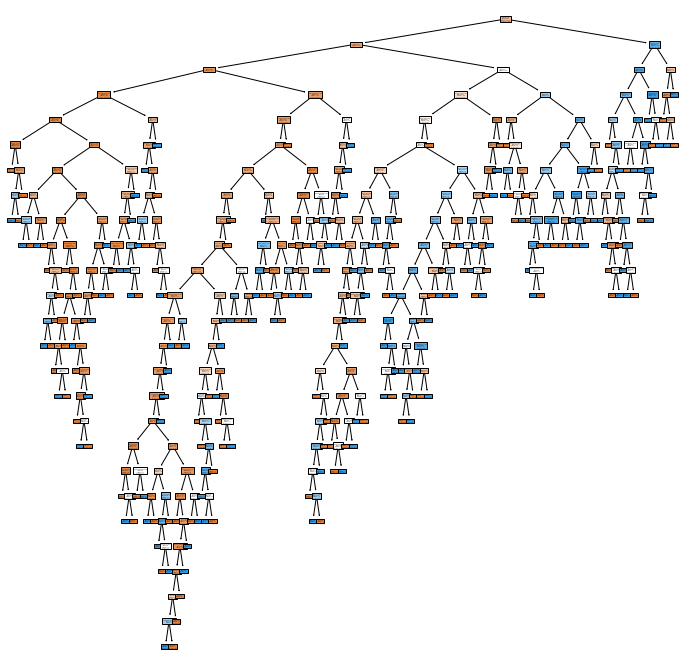

In [94]:
#This cell takes a few minutes to run
plt.figure(figsize=(12,12))
plot_tree(tree, feature_names=X.columns, filled=True)
plt.show()

In [95]:
tree.score(X_test,y_test)

0.7601809954751131

In [96]:
tree2 = DecisionTreeClassifier(criterion='entropy')

In [97]:
tree2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [98]:
tree2.score(X_test,y_test)

0.751131221719457

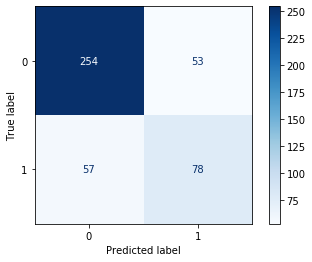

In [99]:
plot_confusion_matrix(tree2, X_test, y_test ,cmap=plt.cm.Blues)
plt.show()

In [100]:
#Special thanks to Lindsey Berlin for this code, I added the confusion matrix
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test ,cmap=plt.cm.Blues)
    plt.show()
    
    train_preds_proba = model.predict_proba(X_train)[:, 1]
    test_preds_proba = model.predict_proba(X_test)[:, 1]  
    
    print('Train Scores:')
    print(f"Accuracy: {model.score(X_train, y_train):.3f}")
    print(f"F1 Score: {f1_score(y_train, train_preds):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_train, train_preds_proba):.3f}")
    print('Test Scores:')
    print(f"Accuracy: {model.score(X_test, y_test):.3f}")
    print(f"F1 Score: {f1_score(y_test, test_preds):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, test_preds_proba):.3f}")\
    


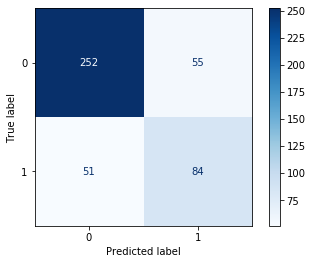

Train Scores:
Accuracy: 1.000
F1 Score: 1.000
ROC-AUC: 1.000
Test Scores:
Accuracy: 0.760
F1 Score: 0.613
ROC-AUC: 0.722


In [101]:
evaluate_model(tree, X_train, X_test, y_train, y_test)

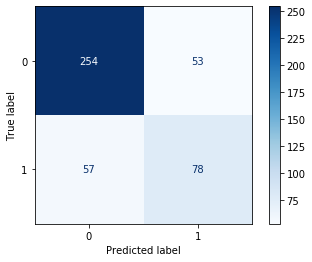

Train Scores:
Accuracy: 1.000
F1 Score: 1.000
ROC-AUC: 1.000
Test Scores:
Accuracy: 0.751
F1 Score: 0.586
ROC-AUC: 0.703


In [102]:
evaluate_model(tree2, X_train, X_test, y_train, y_test)

There's some serious overfitting with the training set, but that's to be expected. Again, I'm not in love with the scores on the test set. But let's keep moving.
Now along with Decision Trees, we'll do a Random Forest.

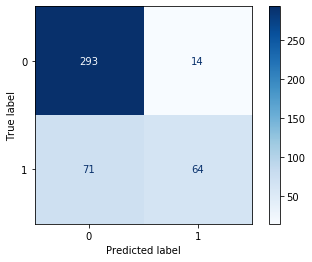

Train Scores:
Accuracy: 0.883
F1 Score: 0.774
ROC-AUC: 0.940
Test Scores:
Accuracy: 0.808
F1 Score: 0.601
ROC-AUC: 0.865


In [103]:
rf1 = RandomForestClassifier(max_depth=7, min_samples_split=10, n_estimators=100, random_state=0)
rf1.fit(X_train, y_train)

evaluate_model(rf1, X_train, X_test, y_train, y_test)


So there's a real issue with predicting the expensive bottles on this model.

Let's try it a few more times, but fiddle with the hyperparameters (that's what they're there for).

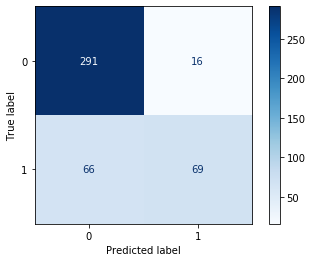

Train Scores:
Accuracy: 0.894
F1 Score: 0.802
ROC-AUC: 0.957
Test Scores:
Accuracy: 0.814
F1 Score: 0.627
ROC-AUC: 0.869


In [104]:
rf2 = RandomForestClassifier(max_depth=10, min_samples_split=15, n_estimators=100, random_state=0)
rf2.fit(X_train, y_train)

evaluate_model(rf2, X_train, X_test, y_train, y_test)

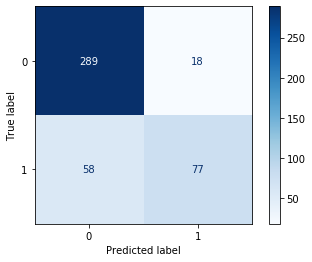

Train Scores:
Accuracy: 0.961
F1 Score: 0.933
ROC-AUC: 0.996
Test Scores:
Accuracy: 0.828
F1 Score: 0.670
ROC-AUC: 0.867


In [105]:
rf3 = RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50, random_state=0)
rf3.fit(X_train, y_train)

evaluate_model(rf3, X_train, X_test, y_train, y_test)

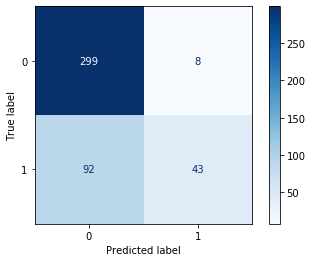

Train Scores:
Accuracy: 0.832
F1 Score: 0.635
ROC-AUC: 0.913
Test Scores:
Accuracy: 0.774
F1 Score: 0.462
ROC-AUC: 0.845


In [106]:
rf4 = RandomForestClassifier(max_depth=5, min_samples_split=15, n_estimators=100, random_state=0)
rf4.fit(X_train, y_train)

evaluate_model(rf4, X_train, X_test, y_train, y_test)

So the deeper we go, the better the scores get, but some of these models are getting more wrong than right.

In [107]:
feats = rf1.feature_importances_
feature_imps = dict(zip(X.columns, feats))
feature_imps

{'Meta Critic': 0.3450085902315811,
 'STDEV': 0.06867386156502786,
 '#': 0.04577546968176978,
 'Ages': 0.31489475853272314,
 'Class_Bourbon-like': 0.003053327958033772,
 'Class_Rye-like': 0.014775088379028932,
 'Class_Scotch-like': 0.003151292212340932,
 'Class_SingleMalt-like': 0.01983059600422198,
 'Cluster_A': 0.006316096259350864,
 'Cluster_B': 0.002383379650119768,
 'Cluster_C': 0.009962678234072868,
 'Cluster_E': 0.006397264428886974,
 'Cluster_F': 0.002467664788080807,
 'Cluster_G': 0.006457372473300611,
 'Cluster_H': 0.0024052317250940845,
 'Cluster_I': 0.0029902425596776113,
 'Cluster_J': 0.007719837647431484,
 'Cluster_R0': 0.0017272960333496062,
 'Cluster_R1': 0.001298766919304654,
 'Cluster_R2': 0.0007725846275398857,
 'Cluster_R3': 0.0019091030507658018,
 'Cluster_R4': 0.0015977918516986162,
 'Cluster_U': 0.02979494383372178,
 'Country_Belgium': 5.011793641205933e-05,
 'Country_Canada': 0.022701467511640056,
 'Country_England': 5.756465554997826e-05,
 'Country_Finland': 0.

In [108]:
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         random_state=1, n_estimators=200)
ada1.fit(X_train, y_train)
ada1.score(X_test,y_test)

0.8099547511312217

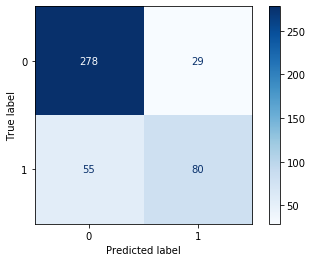

Train Scores:
Accuracy: 1.000
F1 Score: 1.000
ROC-AUC: 1.000
Test Scores:
Accuracy: 0.810
F1 Score: 0.656
ROC-AUC: 0.850


In [109]:
evaluate_model(ada1, X_train, X_test, y_train, y_test)

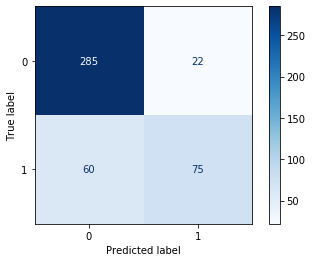

Train Scores:
Accuracy: 1.000
F1 Score: 1.000
ROC-AUC: 1.000
Test Scores:
Accuracy: 0.814
F1 Score: 0.647
ROC-AUC: 0.861


In [110]:
ada2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),
                         random_state=1, n_estimators=200)
ada2.fit(X_train, y_train)
evaluate_model(ada2, X_train, X_test, y_train, y_test)

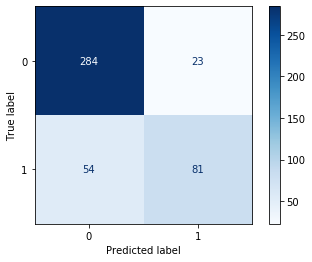

Train Scores:
Accuracy: 1.000
F1 Score: 1.000
ROC-AUC: 1.000
Test Scores:
Accuracy: 0.826
F1 Score: 0.678
ROC-AUC: 0.869


In [111]:
ada3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),
                         random_state=1, n_estimators=200)
ada3.fit(X_train, y_train)
evaluate_model(ada3, X_train, X_test, y_train, y_test)

So increasing the depth on the AdaBoost didn't help the test scores at all. Weird. I guess because it's fitting so well to the training data, it's causing more error in the test set.

Let's see how the Gradient Boosting works.

In [112]:
gbm1 = GradientBoostingClassifier(learning_rate=0.01, random_state=1)
gbm1.fit(X_train, y_train)
gbm1.score(X_test,y_test)

0.7873303167420814

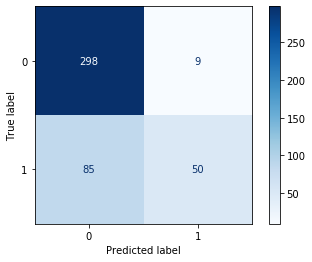

Train Scores:
Accuracy: 0.834
F1 Score: 0.645
ROC-AUC: 0.894
Test Scores:
Accuracy: 0.787
F1 Score: 0.515
ROC-AUC: 0.848


In [113]:
evaluate_model(gbm1, X_train, X_test, y_train, y_test)

In [114]:
gbm2 = GradientBoostingClassifier(learning_rate=0.05, random_state=1)
gbm2.fit(X_train, y_train)
gbm2.score(X_test,y_test)

0.8054298642533937

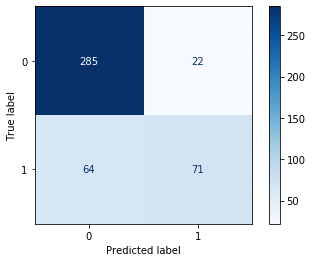

Train Scores:
Accuracy: 0.878
F1 Score: 0.772
ROC-AUC: 0.937
Test Scores:
Accuracy: 0.805
F1 Score: 0.623
ROC-AUC: 0.877


In [115]:
evaluate_model(gbm2, X_train, X_test, y_train, y_test)

In [116]:
gbm3 = GradientBoostingClassifier(learning_rate=0.1, random_state=1)
gbm3.fit(X_train, y_train)
gbm3.score(X_test,y_test)

0.8167420814479638

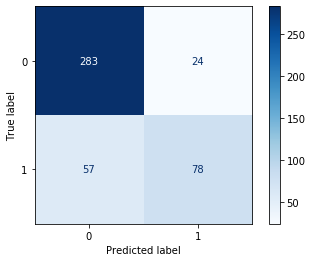

Train Scores:
Accuracy: 0.899
F1 Score: 0.819
ROC-AUC: 0.957
Test Scores:
Accuracy: 0.817
F1 Score: 0.658
ROC-AUC: 0.885


In [117]:
evaluate_model(gbm3, X_train, X_test, y_train, y_test)

So now let's try the XGBoost: 

In [118]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

xgb1.fit(X_train, y_train)
xgb1.score(X_test,y_test)

0.7828054298642534

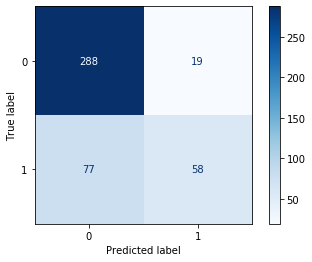

Train Scores:
Accuracy: 0.840
F1 Score: 0.688
ROC-AUC: 0.889
Test Scores:
Accuracy: 0.783
F1 Score: 0.547
ROC-AUC: 0.843


In [119]:
evaluate_model(xgb1, X_train, X_test, y_train, y_test)

In [120]:
xgb2 = xgb.XGBClassifier(random_state=1, learning_rate=0.05)
xgb2.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, random_state=1)

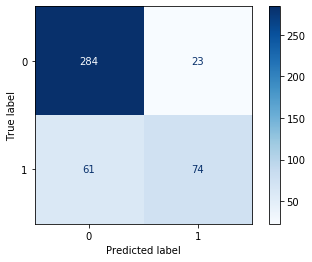

Train Scores:
Accuracy: 0.865
F1 Score: 0.751
ROC-AUC: 0.928
Test Scores:
Accuracy: 0.810
F1 Score: 0.638
ROC-AUC: 0.873


In [121]:
evaluate_model(xgb2, X_train, X_test, y_train, y_test)

In [122]:
xgb3 = xgb.XGBClassifier(random_state=1, learning_rate=0.1)
xgb3.fit(X_train, y_train)

XGBClassifier(random_state=1)

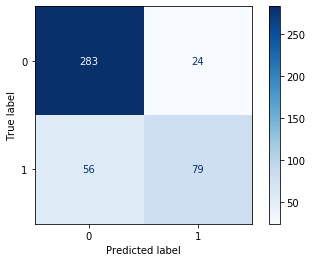

Train Scores:
Accuracy: 0.884
F1 Score: 0.790
ROC-AUC: 0.946
Test Scores:
Accuracy: 0.819
F1 Score: 0.664
ROC-AUC: 0.885


In [123]:
evaluate_model(xgb3, X_train, X_test, y_train, y_test)

In [124]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [3, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_testing_score = gs_tree.score(X_test, y_test)
gs_tree.best_params_


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 20}

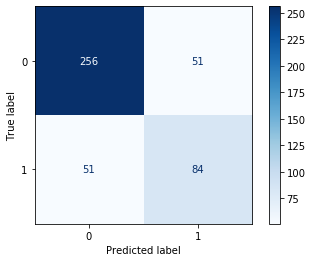

Train Scores:
Accuracy: 0.883
F1 Score: 0.804
ROC-AUC: 0.946
Test Scores:
Accuracy: 0.769
F1 Score: 0.622
ROC-AUC: 0.798


In [125]:
gs_testing_score
evaluate_model(gs_tree, X_train, X_test, y_train, y_test)

Let's look at these, and see how they compare.

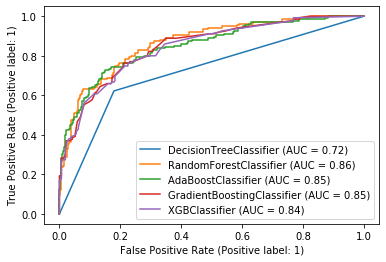

In [126]:
models = [tree, rf1, ada1, gbm1, xgb1]

fig, ax = plt.subplots()

for model in models:
    plot_roc_curve(model, X_test, y_test, ax=ax)

In [127]:
svc_lin1 = SVC(kernel='linear', C=1)
svc_lin1.fit(X_train, y_train)

y_pred_train = svc_lin1.predict(X_train)
y_pred_test = svc_lin1.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       307
           1       0.72      0.53      0.61       135

    accuracy                           0.79       442
   macro avg       0.77      0.72      0.74       442
weighted avg       0.79      0.79      0.78       442

Train accuracy: 0.8466
Test accuracy: 0.7941


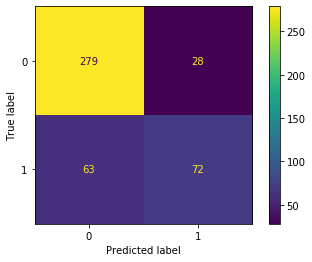

In [128]:
print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_lin1, X_test, y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       307
           1       0.78      0.32      0.45       135

    accuracy                           0.76       442
   macro avg       0.77      0.64      0.65       442
weighted avg       0.77      0.76      0.73       442

Train accuracy: 0.7952
Test accuracy: 0.7647


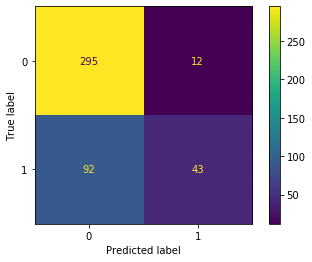

In [129]:
svc_rbf1 = SVC(kernel='rbf', C=1, gamma='scale') 
svc_rbf1.fit(X_train, y_train)

y_pred_train = svc_rbf1.predict(X_train)
y_pred_test = svc_rbf1.predict(X_test)
print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_rbf1, X_test, y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       307
           1       0.80      0.30      0.44       135

    accuracy                           0.76       442
   macro avg       0.78      0.64      0.65       442
weighted avg       0.77      0.76      0.73       442

Train accuracy: 0.8005
Test accuracy: 0.7647


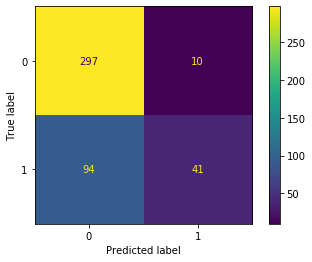

In [130]:
svc_poly1 = SVC(kernel='poly', C=1, gamma='scale', degree=3) # using mostly default values here
svc_poly1.fit(X_train, y_train)

y_pred_train = svc_poly1.predict(X_train)
y_pred_test = svc_poly1.predict(X_test)
print(classification_report(y_test, y_pred_test)) 
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

plot_confusion_matrix(svc_poly1, X_test, y_test)
plt.show()

It looks like the clear winner of the SVM is the linear kernel at least it has more correct True predictions than incorrect. So let's use linear and try different C values.

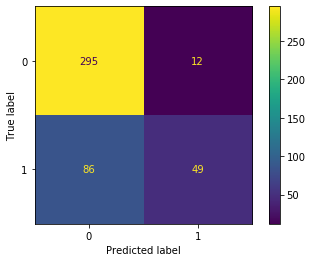

-----
Results at C = 0.01
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       307
           1       0.80      0.36      0.50       135

    accuracy                           0.78       442
   macro avg       0.79      0.66      0.68       442
weighted avg       0.78      0.78      0.75       442

Train accuracy: 0.8156
Test accuracy: 0.7783


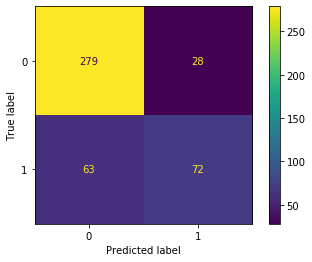

-----
Results at C = 1
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       307
           1       0.72      0.53      0.61       135

    accuracy                           0.79       442
   macro avg       0.77      0.72      0.74       442
weighted avg       0.79      0.79      0.78       442

Train accuracy: 0.8466
Test accuracy: 0.7941


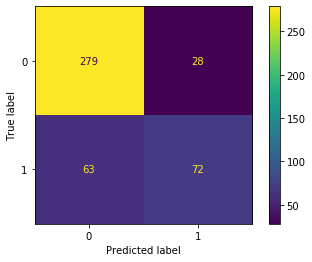

-----
Results at C = 10
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       307
           1       0.72      0.53      0.61       135

    accuracy                           0.79       442
   macro avg       0.77      0.72      0.74       442
weighted avg       0.79      0.79      0.78       442

Train accuracy: 0.8534
Test accuracy: 0.7941


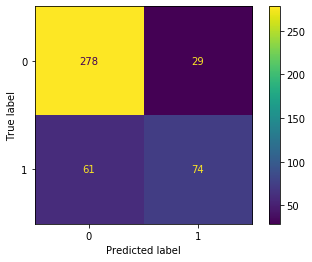

-----
Results at C = 100
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       307
           1       0.72      0.55      0.62       135

    accuracy                           0.80       442
   macro avg       0.77      0.73      0.74       442
weighted avg       0.79      0.80      0.79       442

Train accuracy: 0.8541
Test accuracy: 0.7964


In [131]:
for c in [.01,1,10,100]:  
    svc_c = SVC(kernel='linear', C=c, gamma='scale') # going linear again
    svc_c.fit(X_train, y_train)

    y_pred_train = svc_c.predict(X_train)
    y_pred_test = svc_c.predict(X_test)
    plot_confusion_matrix(svc_c, X_test, y_test)
    plt.show()
    
    print("-----")
    print(f'Results at C = {c}')
    print(classification_report(y_test, y_pred_test)) 
    print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

It looks like we're reaching an upper limit of .85/.79 with C=10, anything above that seems to not matter.
So just to try something else, I want to see what scores we get when we don't use the meta critic data.

In [132]:
X.head()

,Meta Critic,STDEV,#,Ages,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
0,9.57,0.24,3,10,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,9.48,0.23,3,42,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9.42,0.23,4,27,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9.29,0.26,17,40,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,9.24,0.22,21,25,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [133]:
drops=['Meta Critic','STDEV','#']

In [134]:
X2=X.drop(drops, axis=1)

In [135]:
X2.head()

,Ages,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,Cluster_C,Cluster_E,Cluster_F,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
0,10,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,42,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,27,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,40,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,25,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [136]:
X_train,X_test,y_train,y_test=train_test_split(X2,y,test_size= 0.25, random_state=42)

In [137]:
model_log2 = logreg.fit(X_train, y_train).decision_function(X_test)

In [138]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)


Confusion Matrix:
 [[275  32]
 [ 75  60]]


In [139]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))


0    335
1    107
dtype: int64
------------------------------------
0    0.757919
1    0.242081
dtype: float64


So this model is slightly worse. Let's see how the best performing tree model does.

In [140]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

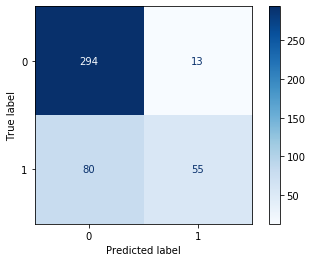

Train Scores:
Accuracy: 0.868
F1 Score: 0.736
ROC-AUC: 0.914
Test Scores:
Accuracy: 0.790
F1 Score: 0.542
ROC-AUC: 0.806


In [141]:
evaluate_model(tree, X_train, X_test, y_train, y_test)

In [142]:
xgb3.fit(X_train, y_train)

XGBClassifier(random_state=1)

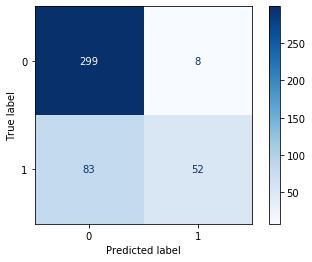

Train Scores:
Accuracy: 0.840
F1 Score: 0.666
ROC-AUC: 0.873
Test Scores:
Accuracy: 0.794
F1 Score: 0.533
ROC-AUC: 0.796


In [143]:
evaluate_model(xgb3, X_train, X_test, y_train, y_test)

So it looks like eliminating those columns made the model worse.

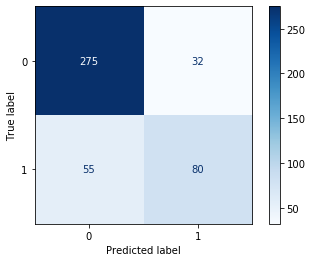

Train Scores:
Accuracy: 0.847
F1 Score: 0.734
ROC-AUC: 0.898
Test Scores:
Accuracy: 0.803
F1 Score: 0.648
ROC-AUC: 0.806


In [174]:
tree4=DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_split=10)
tree4.fit(X_train,y_train)
evaluate_model(tree4, X_train, X_test, y_train, y_test)

So this was one of the best performing models originally, and now the values in the confusion matrix are completely backwards. So it turns out the other columns were needed. I'll put them back here shortly.

In [145]:
test_pred=tree4.predict(X_test)

In [146]:
test_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [147]:
y_test

1559    0
212     0
1682    0
836     0
1245    0
       ..
1624    0
1755    0
1318    0
1193    0
985     0
Length: 442, dtype: int64

In [150]:
test_df=pd.DataFrame(y_test, columns=['actual'])

In [151]:
test_df['pred']=test_pred

In [155]:
test_df.loc[(test_df.actual==0)&(test_df.pred==1)]

,actual,pred
251,0,1
65,0,1
755,0,1
49,0,1
289,0,1
543,0,1


In [154]:
X_test

,Ages,Class_Bourbon-like,Class_Rye-like,Class_Scotch-like,Class_SingleMalt-like,Cluster_A,Cluster_B,Cluster_C,Cluster_E,Cluster_F,...,Country_Wales,Type_Barley,Type_Blend,Type_Bourbon,Type_Flavoured,Type_Grain,Type_Malt,Type_Rye,Type_Wheat,Type_Whiskey
1561,2,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
212,15,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1684,3,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
837,12,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1247,3,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,2,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1757,2,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1320,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1195,18,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


So every model I've run has had some incorrect guesses. Perhaps there's a way to use these, as recommendations: whiskies that the model thinks are expensive ("should be" expensive) but are actually cheap.

In [157]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size= 0.25, random_state=42)

In [176]:
tree=DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_split=10)

In [177]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10)

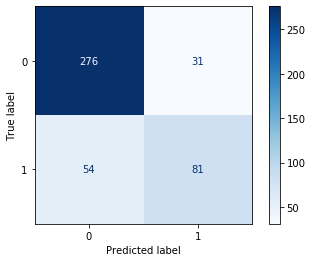

Train Scores:
Accuracy: 0.847
F1 Score: 0.734
ROC-AUC: 0.898
Test Scores:
Accuracy: 0.808
F1 Score: 0.656
ROC-AUC: 0.814


In [178]:
evaluate_model(tree, X_train, X_test, y_train, y_test)

In [179]:
tree_test_pred=tree.predict(X_test)

In [180]:
tree_test_df=pd.DataFrame(y_test, columns=['actual'])

In [181]:
tree_test_df['pred']=tree_test_pred

In [182]:
tree_test_df

,actual,pred
1559,0,1
212,0,0
1682,0,0
836,0,0
1245,0,0
...,...,...
1624,0,0
1755,0,0
1318,0,0
1193,0,0


In [183]:
act_cheap=test_df.loc[(test_df.actual==0)&(test_df.pred==1)]

In [184]:
act_cheap

,actual,pred
251,0,1
65,0,1
755,0,1
49,0,1
289,0,1
543,0,1


I have to go back to df1 for the names. So I can iterate over the index in my cheap dataframe and grab some names.

In [185]:
df1.head()

,Whisky,Meta Critic,STDEV,#,Class,Cluster,Country,Type
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.57,0.24,3,SingleMalt-like,A,Scotland,Malt
1,Ledaig 42yo Dusgadh,9.48,0.23,3,SingleMalt-like,C,Scotland,Malt
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,0.23,4,SingleMalt-like,C,Scotland,Malt
3,Glenfarclas 40yo,9.29,0.26,17,SingleMalt-like,A,Scotland,Malt
4,Glengoyne 25yo,9.24,0.22,21,SingleMalt-like,A,Scotland,Malt


In [186]:
act_cheap['name']='Unknown'

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [187]:
act_cheap

,actual,pred,name
251,0,1,Unknown
65,0,1,Unknown
755,0,1,Unknown
49,0,1,Unknown
289,0,1,Unknown
543,0,1,Unknown


In [188]:
for i in act_cheap['name'].index:
    act_cheap.at[i,'name']=df1.at[i,'Whisky']

In [189]:
act_cheap

,actual,pred,name
251,0,1,Aberfeldy 18yo
65,0,1,BenRiach 17yo Solstice 2nd Peated Port Finish
755,0,1,Glen Grant 10yo (G&M)
49,0,1,BenRiach 17yo Solstice Peated Port (both editi...
289,0,1,Singleton of Glen Ord 18yo
543,0,1,Singleton of Glendullan 18yo


# Conclusion

There are a few models here that have some serious potential and could really work in predicting the expensiveness of a bottle of whisky. All in all, I'm pretty satisfied with how this turned out. I think there's still a lot to play with and explore to get the models better, perhaps some research to eliminate the unknown cluster.